SAC处理连续动作

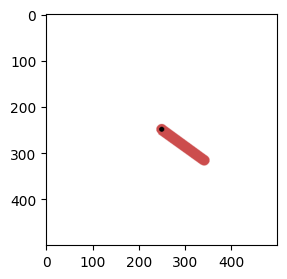

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class ModelAction(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        state = self.s(state)
        return self.mu(state), self.sigma(state).exp()


model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[-0.1737],
         [-0.1821]], grad_fn=<TanhBackward0>),
 tensor([[0.9647],
         [1.0331]], grad_fn=<ExpBackward0>))

In [3]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value1_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value2_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value1_next.load_state_dict(model_value1.state_dict())
model_value2_next.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[0.0495],
        [0.0173]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #根据概率采样
        mu, sigma = model_action(torch.FloatTensor(state).reshape(1, 3))
        action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


50.18364334091151

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_53312\3624659836.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([-0.4574753, -0.8892223, -0.1523546], dtype=float32),
  -0.08582825280886751,
  0.4764671205789315,
  array([-0.4946264, -0.8691057, -0.8450198], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=5e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_action_entropy(state):
    mu, sigma = model_action(torch.FloatTensor(state).reshape(-1, 3))
    dist = torch.distributions.Normal(mu, sigma)

    action = dist.rsample()

    #求分布的熵
    entropy = dist.entropy()

    return action, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


alpha = 1.0

In [7]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)
    requires_grad(model_action, False)

    #计算target
    with torch.no_grad():
        #计算动作和熵
        next_action, entropy = get_action_entropy(next_state)

        #评估next_state的价值
        input = torch.cat([next_state, next_action], dim=1)
        target1 = model_value1_next(input)
        target2 = model_value2_next(input)
        target = torch.min(target1, target2)

    #加权熵,熵越大越好
    target = target + alpha * entropy
    target = target * 0.99 * (1 - over) + reward

    #计算value
    value = model_value1(torch.cat([state, action], dim=1))
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    value = model_value2(torch.cat([state, action], dim=1))
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

2.7056477069854736

In [8]:
def train_action(state):
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, True)

    #计算action和熵
    action, entropy = get_action_entropy(state)

    #计算value
    value1 = model_value1(torch.cat([state, action], dim=1))
    value2 = model_value2(torch.cat([state, action], dim=1))
    value = torch.min(value1, value2)

    #加权熵,熵越大越好
    loss = -(value + alpha * entropy).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-1.4387047290802002

In [9]:
def train():
    global alpha
    model_action.train()
    model_value1.train()
    model_value2.train()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            train_action(state)
            soft_update(model_value1, model_value1_next)
            soft_update(model_value2, model_value2_next)

        alpha *= 0.95

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), alpha, test_result)


train()

0 400 0.95 44.43550281240689
20 4400 0.34056162628811465 38.34718580118911
40 8400 0.12208654873684793 64.59649048880117
60 12400 0.04376630903760433 71.43288939666132
80 16400 0.015689605665762895 162.3755538102218
100 20000 0.0056245027593172965 174.43796473100485
120 20000 0.0020163050597632503 180.94919359176754
140 20000 0.0007228169792062388 175.7670997997068
160 20000 0.00025911971152330434 180.2033051016775
180 20000 9.289076879966704e-05 180.39377040707137


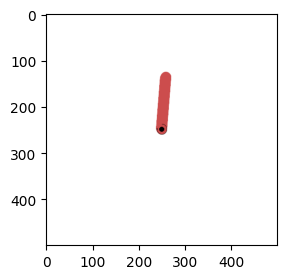

184.11492053995

In [10]:
play(True)[-1]